In [1]:
"""
this script displays some of the working principles of the cell_tracker package and track a synthetic cell
"""

%load_ext autoreload
%autoreload 2

import os
import sys
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import argparse
import _pickle as cPickle
import datetime as dt
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt

from cell_tracker import Cell, track_cells, label_local_maximas, get_new_labels

In [2]:
# setup the synthetic cell data

N = 100 # number of gridpoints in x direction
M = 100 # number of gridpoints in y direction

timesteps = 12
timestep = 5 # minutes
start_day = pd.to_datetime("20210715", format="%Y%m%d")

datelist = pd.date_range(start_day, periods=timesteps, freq=str(timestep)+"min")

field_static = {}
field_static["lat"] = np.linspace(0, 10, N).repeat(M).reshape(N, M)
field_static["lon"] = np.linspace(0, 10, M).repeat(N).reshape(M, N).T

In [3]:

# create a field with moving cells
fields = np.zeros((timesteps, N, M))

x_0 = 15 # initial x position
y_0 = 15 # initial y position
v_x = 5 # x velocity (gridpoints per timestep)
v_y = 5 # y velocity (gridpoints per timestep)
cell_size = 20 # cell size in gridpoints
intensity = 20 # cell intensity
fade = 4 # cell fade
# create a gaussian cell
cell = np.zeros((cell_size, cell_size))
for i in range(cell_size):
    for j in range(cell_size):
        cell[i, j] = intensity * fade*(np.exp(-((i-cell_size/2)**2 + (j-cell_size/2)**2)/(2*cell_size**2))-(1-1/fade))

for i, date in enumerate(datelist):

    # get the current position
    x = int(x_0 + v_x * i)
    y = int(y_0 + v_y * i)

    # add the cell to the field
    fields[i, x:x+cell_size, y:y+cell_size] = cell

In [4]:
# track the cells
cells = track_cells(fields, datelist, field_static)

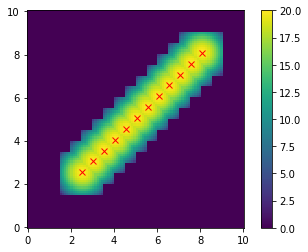

In [5]:
# plot the field
plt.pcolormesh(field_static["lon"], field_static["lat"], fields[:, :, :].max(axis=0))
plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(cells[0].lon, cells[0].lat, "rx")

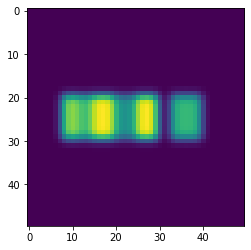

In [7]:
# setup synthetic data to showcase the segmentation

size = 50
field = np.zeros((size, size))

field[8:12, 20:30] = 25
field[12:20, 20:30] = 20
field[15:20, 20:30] = 30
field[20:25, 20:30] = 15
field[25:30, 20:30] = 30
field[33:40, 20:30] = 20
# field[20:25, 40:45] = 30
field = field.T
field = gaussian_filter(field, sigma=1)

# add some noise
plt.imshow(field)

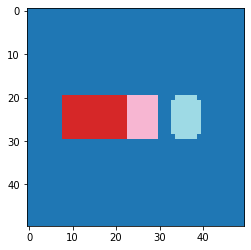

In [8]:
# show the labeled cell masks

kwargs = {'prominence': 5, 'threshold': 10, 'min_distance': 5,'fill_method': 'watershed', 'aura':0}
labeled, above_threshold = label_local_maximas(field,**kwargs)
new_cell_labels = get_new_labels(labeled, 5)

for i in range(size):
    for j in range(size):
        if labeled[i,j] not in new_cell_labels:
            labeled[i,j] = 0
plt.imshow(labeled, cmap='tab20')


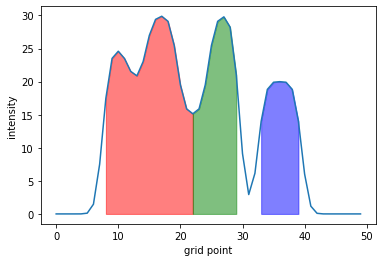

In [9]:
# visualization (crosssection) of the watershed segmentation
plt.plot(field[25,:])
plt.ylabel('intensity')
plt.xlabel('grid point')
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w']

masks = []
for label in new_cell_labels:
    masks.append(labeled[25,:]==label)
masks[1][22] = True

for i,label in enumerate(new_cell_labels):
    plt.fill_between(np.arange(size), field[25,:], 0, where=masks[i], color=colors[i], alpha=0.5)